### drift

Two types of drift:
- concept drift - when the relationship between input and target changes over time
- (input) feature drift - check each feature with statistical distance measures that indicate changes in its distribution over time (i.e. the time between train and prod)

Types of feature drift issues:
- new categories (caused by new products, or, tokens not seen before)
- date string changes format
- different sources of features leading to  data with different indexes, or, scale, or, coordinate 
- missing data (caused by data fails)

Notes:
- reference window (i.e. train data) can be fixed (distribution doesn't change), or, a moving time window (distribution can change).
- popular data drift packages won't install into Jupyter Notebook (e.g. evidently, alibi-detect)

In [1]:
import json
import model
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np

In [3]:
import shap
import matplotlib.pyplot as plt

C:\Users\marke\anaconda3\envs\py38\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\marke\anaconda3\envs\py38\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [4]:
from data_drift_detector import DataDriftDetector

In [5]:
import sys
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [6]:
#pd.set_option('precision', 4)

#### load both test and train data

In [7]:
# load
data_train_df = pd.read_parquet("./output/data_train_df.parquet")
data_test_df = pd.read_parquet("./output/data_test_df.parquet")

In [8]:
# n.b. put 'target' into categorical features
cat_cols = ['target', 'sex', 'marital_status', 'education', 'occupation', 'dual_income','household_status','type_of_home', 'ethnic_class', 'language']
num_cols=['age', 'years_in_sf', 'household_members', 'under_18']

In [9]:
# convert target to str (categorical)
# data_train_df.target = data_train_df.target.astype('category')
# data_test_df.target = data_test_df.target.astype('category')

### run drift detector

In [10]:
# initialise the detector
detector = DataDriftDetector(df_prior=data_train_df,
                            df_post=data_test_df,
                            categorical_columns=cat_cols,
                            numeric_columns=num_cols)

- DataDriftDetector() is an object to assess data drift between two dataframes (df_prior and df_post).
- .calculate_drift() returns a dictionary containing the column name and the corresponding statistics between the respective column in the prior and post dataframe. 
- For each feature (or column), the Jensen Shannon (JS) distance and L-infinity-norm (categorical data only) is calculated, along with a statistical test for similarity (numerical Kolgmorov-Smirnoff, categorical Chi-sq)
- Both jensen shannon distance and l-infinity-norm are distance scales between 0 and 1. High distances (e.g. greater than 0.05) suggest greater data drift. 
- Low p values suggest a significant difference in distribution. (e.g. less than 0.05)
- JS distance is a symmetric bounded variant of relative entropy (or Kullback-Leibler divergence) with a 0–1 range.
- Categorical data only: L-infinity distance is the maximum absolute difference in relative probability of each category (min is 0, max is 1) - so you can have lots of categories & its robust to noise

- Other metrics are calculated in the detector but I've chosen not to return them as their scales require interpreting e.g. wasserstein (earth movers distance), population stability index

#### generate results into a dataframe and apply formatting

In [11]:
# https://pandas.pydata.org/pandas-docs/version/1.1/user_guide/style.html

In [12]:
def color_above_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for values above 0.05, black otherwise.
    """
    color = 'red' if val > 0.05 else 'black'
    return 'color: %s' % color

In [13]:
def color_below_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for values less than 0.05, black otherwise.
    """
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

In [14]:
# categorical features
cat_df = pd.DataFrame.from_dict(detector.calculate_drift()['categorical']).T
cat_df.style.applymap(color_above_red, subset=['l_infinity_norm', 'jensen_shannon_divergence']).applymap(color_below_red, subset=['chi_square_test_p_value'])

,chi_square_test_p_value,jensen_shannon_divergence,l_infinity_norm
target,0.295000,0.000019,0.006130
sex,0.093000,0.000049,0.009854
marital_status,0.000000,0.000708,0.022905
education,0.054000,0.000202,0.006020
occupation,0.000000,0.000756,0.013921
dual_income,0.888000,0.000004,0.001987
household_status,0.125000,0.000106,0.006835
type_of_home,0.021000,0.000223,0.017251
ethnic_class,0.000000,0.000842,0.010021
language,0.000000,0.000502,0.010321


In [15]:
# numerical features
num_df = pd.DataFrame.from_dict(detector.calculate_drift()['numerical']).T
num_df.style.applymap(color_above_red, subset=['jensen_shannon_divergence']).applymap(color_below_red, subset=['ks_2sample_test_p_value'])

,ks_2sample_test_p_value,jensen_shannon_divergence
age,0.211170,0.007194
years_in_sf,0.211170,0.012219
household_members,0.469506,0.006326
under_18,0.368188,0.012685


### feature visualisation: train v prod

Plotting the following numeric column(s): age, years_in_sf, household_members, under_18


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


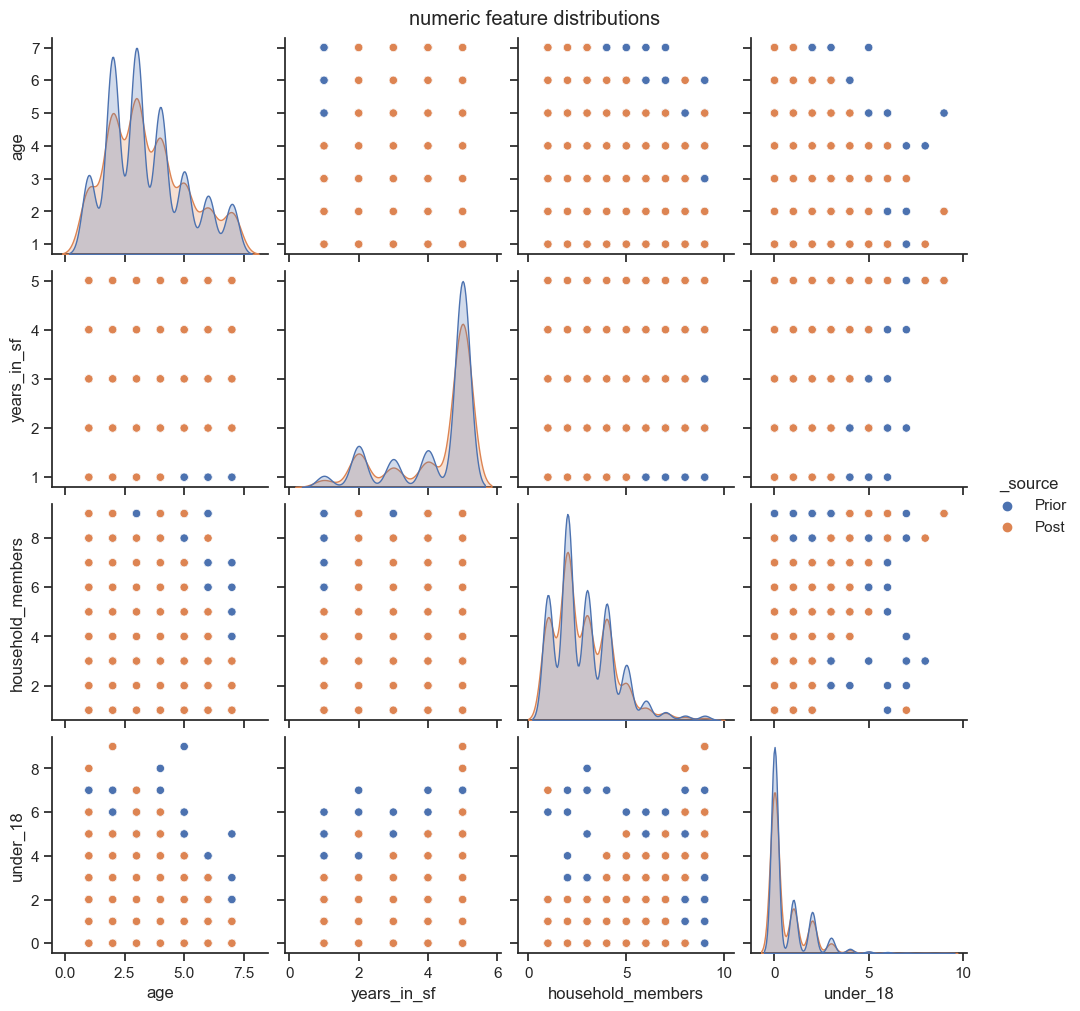

In [16]:
# plot numeric columns against each other in a pair grid
detector.plot_numeric_to_numeric(
    plot_kws={'alpha': 1},
    diag_kws={'common_norm': False},
    plot_numeric_columns=num_cols
)

In [17]:
detector.plot_categorical_to_numeric(
    grid_kws={'height': 3},
    plot_kws={'scale': 'area'},
    plot_numeric_columns = num_cols
)

Plotting the following categorical column(s): sex, marital_status, education, occupation, dual_income, household_status, type_of_home, ethnic_class, language, target
Against the following numeric column(s):age, years_in_sf, household_members, under_18
Categorical columns with high cardinality (>20 unique values) are not plotted.


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Plotting the following categorical column(s): target, sex, marital_status, education, occupation, dual_income, household_status, type_of_home, ethnic_class, language


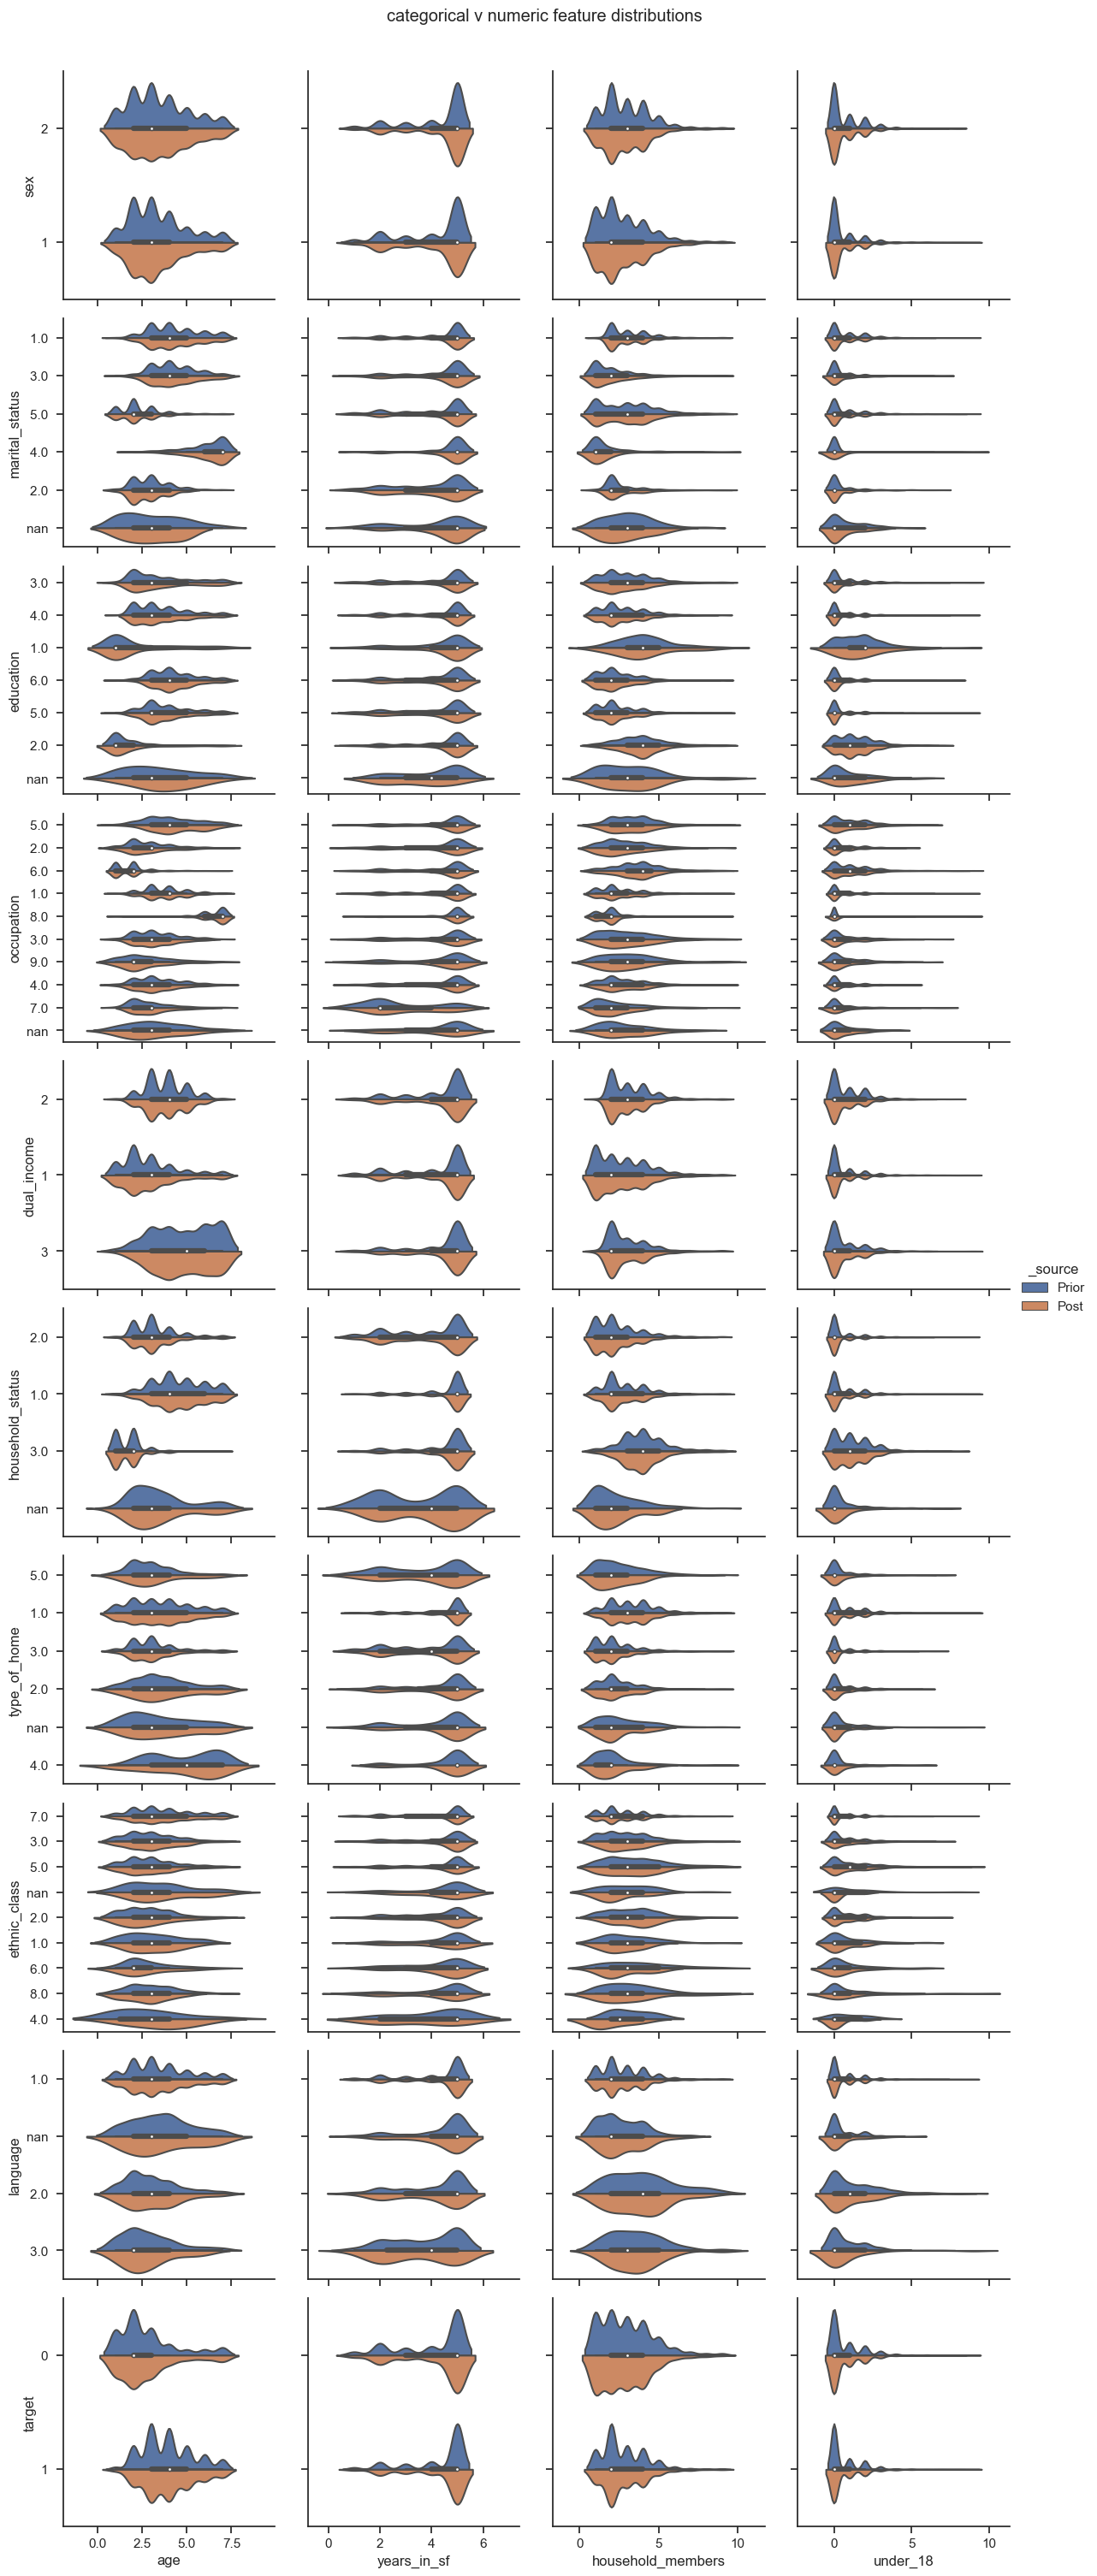

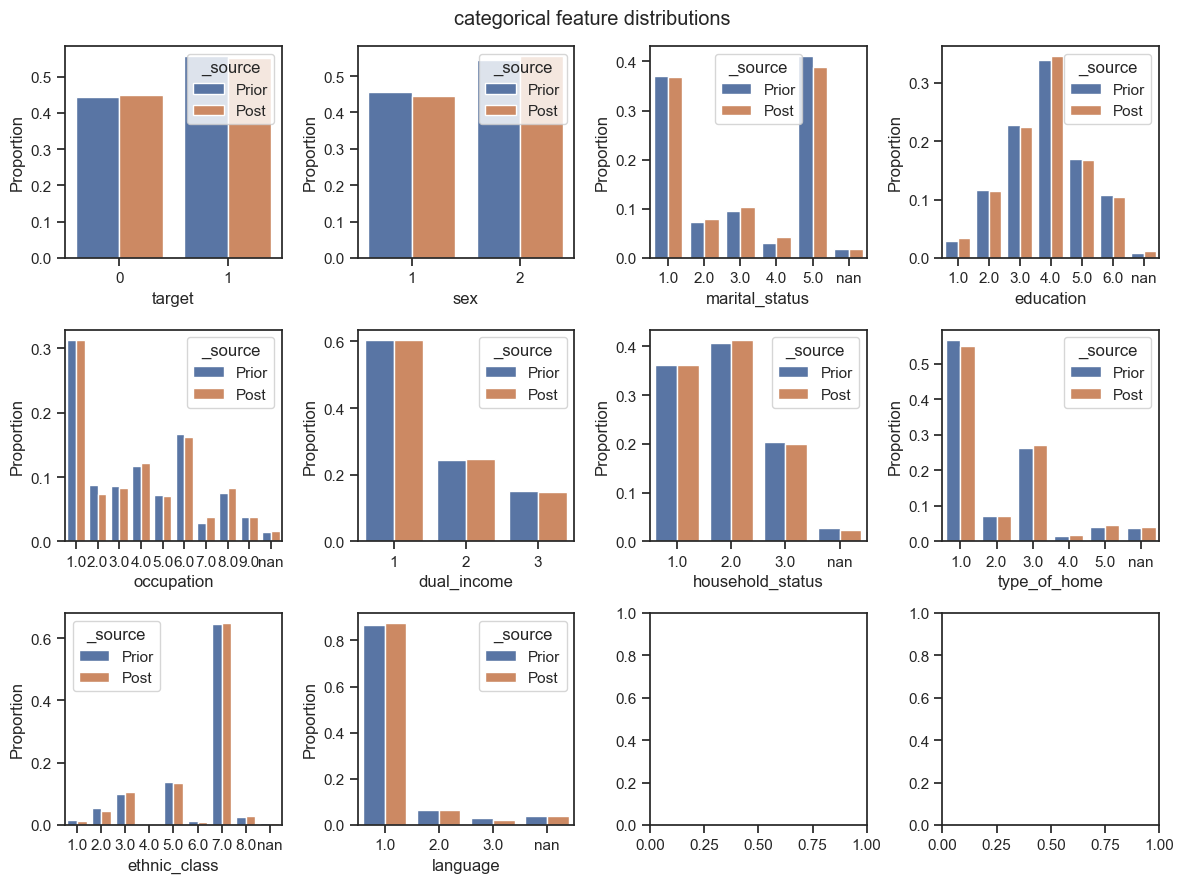

In [18]:
# plot categorical columns against each other
detector.plot_categorical(
    plot_categorical_columns=cat_cols
)

### Model of both Train and Test (i.e. look for concept drift)

In [19]:
### uses a random forest model to assess efficacy
#detector.compare_ml_efficacy(target_column='target', test_data=data_test_df )

#### to do: population stability index and compare results of 2 models

### Tensorflow data validation

In [20]:
# code is here: https://github.com/tensorflow/metadata/tree/master/tensorflow_metadata/proto/v0

In [21]:
# https://www.tensorflow.org/tfx/data_validation/get_started#checking_data_skew_and_drift

In [22]:
# https://medium.com/@deeptij2007/tensorflow-data-validation-tfdv-5e36fc74d19a

In [23]:
# https://github.com/deeptij2007/Tensorflowextended-TFX-/blob/main/Tensorflow%20data%20validation.ipynb

In [24]:
import tensorflow_data_validation as tfdv

Using Any for unsupported type: typing.Sequence[~T]


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

ImportError: initialization failed

#### generate statistics from dataframe (or, csv, or, tsobject)

In [ ]:
train_stats = tfdv.generate_statistics_from_dataframe(data_train_df)
test_stats = tfdv.generate_statistics_from_dataframe(data_test_df)

#### visualise statistics

In [ ]:
tfdv.visualize_statistics(lhs_statistics=train_stats,rhs_statistics=test_stats,lhs_name='TRAIN',rhs_name='PROD')

In [ ]:
tfdv.visualize_statistics(lhs_statistics=train_stats,rhs_statistics=test_stats,lhs_name='TRAIN',rhs_name='PROD')

In [ ]:
type(train_stats)

In [ ]:
# generate schema of training data
schema_train =tfdv.infer_schema(statistics=test_stats)
tfdv.display_schema(schema_train)

### check for anomalies

In [ ]:
anomalies=tfdv.validate_statistics(statistics=train_stats, schema=schema_train)
tfdv.display_anomalies(anomalies)

### check for distribution skew (categorical & non-categorcal data)

In [ ]:
# Categorical skew:
# Add a skew comparator to schema for 'payment_type' and set the threshold
# of L-infinity norm for triggering skew anomaly to be 0.01.

# Either numerical or categorical skew:
# jensen_shannon_divergence

#### categorical features

In [ ]:
# Categorical skew:
# Add a skew comparator to schema for 'payment_type' and set the threshold
# of L-infinity norm for triggering skew anomaly to be 0.01.
# n.b. you can also use jensen_shannon_divergence

In [ ]:
inf_norm_threshold = 0.05

In [ ]:
for c in cat_cols:
    tfdv.get_feature(
            schema_train, c
        ).skew_comparator.infinity_norm.threshold = inf_norm_threshold

#### numerical features

In [ ]:
# Either numerical or categorical skew:
# jensen_shannon_divergence: based upon relative entropy of two probability distributions. Pro: can handle missing data, symmetric (from one distribution to the other) and lies between 0 and 1.

In [ ]:
jensen_shannon_divergence_threshold = 0.05 # zero is no difference between probability distributions, 1 is the maximum divergence

In [ ]:
for n in num_cols:
    tfdv.get_feature(
            schema_train, n
        ).skew_comparator.jensen_shannon_divergence.threshold = jensen_shannon_divergence_threshold

#### check each feature

In [ ]:
skew_anomalies = tfdv.validate_statistics(statistics = train_stats, 
                                          schema = schema_train,
                                          previous_statistics=train_stats,
                                          serving_statistics=test_stats)

tfdv.display_anomalies(skew_anomalies)

In [ ]:
skew_anomalies

# Check Jensen_Shannon_Divergence: investigate difference between tensorfow  and DataDriftDetector

In [ ]:
# dummy categorical data
p_df = pd.DataFrame({'col1': ['A','A','B','B','B','C','C','C','C','C']}) # i.e. prob =  [0.2, 0.3, 0.5]
q_df = pd.DataFrame({'col1': ['A','A','A','B','B','B','B','C','C','C']}) # i.e. prob =  [0.3, 0.4, 0.3]

# dummy numerical data
r_df = pd.DataFrame({'col2': [4,4,4,4,4,4,4,4,4,5]}) # i.e. prob =  ?
s_df = pd.DataFrame({'col2': [2,2,2,3,3,3,4,4,5,6]}) # i.e. prob =  ?

In [ ]:
t_df = pd.concat([p_df,r_df],axis=1)
u_df= pd.concat([q_df,s_df],axis=1)

#### DataDriftDetecter

In [ ]:
# initialise the detector
detector = DataDriftDetector(df_prior=t_df,
                            df_post=u_df,
                            categorical_columns=['col1'],
                            numeric_columns=['col2'])

In [ ]:
detector.calculate_drift(steps=10)

#### scipy check

In [ ]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np

def JSD(P, Q):
    # jensen shannon divergence
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [ ]:
P = [1.2585954819487288e-22, 5.2399898520210666e-14, 1.5272623794071564e-07, 0.003116275123342156, 0.44514024737652197, 0.4451863764590803, 0.025896463477369732, 0.07875414487195767, 0.001906017026877615, 3.229385601080744e-07]
Q = [0.1190275674550828, 0.13949459162360278, 0.14423594480632052, 0.13577352841378634, 0.11916750079507676, 0.0995532448500109, 0.08106841488084421, 0.0659605895975998, 0.05372930404293067, 0.041989313534745186]
JSD(P,Q)

In [ ]:
R = [0.2, 0.3, 0.5]
S = [0.3, 0.4, 0.3]
JSD(R,S)

#### tensorflow data validation

In [ ]:
train_stats = tfdv.generate_statistics_from_dataframe(t_df)
test_stats = tfdv.generate_statistics_from_dataframe(u_df)

In [ ]:
# generate schema of training data
schema_train =tfdv.infer_schema(statistics=test_stats)
tfdv.display_schema(schema_train)

In [ ]:
for c in ['col1','col2']:
    tfdv.get_feature(
            schema_train, c
        ).skew_comparator.jensen_shannon_divergence.threshold = inf_norm_threshold

In [ ]:
skew_anomalies = tfdv.validate_statistics(statistics = train_stats, 
                                          schema = schema_train,
                                          previous_statistics=train_stats,
                                          serving_statistics=test_stats)

tfdv.display_anomalies(skew_anomalies)

In [ ]:
skew_anomalies